# LAB: Random Projections : SOLUTIONS


#### Authors: R. M. Gower

## Aim

The aim of this material is to
- to show that in practice dimension reduction can be used with no loss of accuracy on some problem
- code efficient sparse random projections
- apply sparse random projections together with knearestneighbors


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- Each paris of students must send their jupyter notebook **before the 24th of November at 21:59** to **gowerrobert@gmail.com**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "julien"
ln1 = "guegan"
fn2 = "jean-jules"
ln2 = "bigeard"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_guegan_julien_and_bigeard_jean-jules.ipynb


In [2]:
#Throughout the notebook you will find commented boxes like this one

### TODO ###   
# please implement blabla
#############

These boxes need to be replaced by code as explained in the boxes.
Solutions will online tomorrow. Good luck!

In [3]:
%matplotlib inline

In [4]:
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt

In [5]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression    #Logistic Regression
from sklearn.neighbors import KNeighborsClassifier 

def get_data(dataname):
    data = load_svmlight_file(dataname)
    return data[0], data[1]

## EXERCISE 1: 

Use LogisticRegression classifier of Scikit-learn to experimentally confirm the following corollary proven in class and test random sparse projections

### Corollary of Range Space Preserving Theorem  

Let 
$$ X^\top = [x_1, \ldots, x_n]^T \in \mathbb{R}^{n\times d},$$
be our data matrix and let
$$  X^\top X = [\hat{x}_1, \ldots, \hat{x}_n]^\top \in \mathbb{R}^{n\times n}. $$
We can find a solution to the following training problem
$$ w^* \in \min_{w \in \mathbb{R}^d}  \frac{1}{n}\sum_{i=1}^n \ell_i(\langle x_i,w \rangle) \hspace{3cm} (I)$$
by instead solving 
$$ \hat{w}^* \in \min_{w \in \mathbb{R}^n}  \frac{1}{n}\sum_{i=1}^n \ell_i(\langle \hat{x}_i,w \rangle) \hspace{3cm} (II)$$
and  $ X \hat{w}^*$ is a solution to $(I)$

**NOTE:** The matrix $X$ is transposed with respect to the data matrix defined in class and in the lectures ! Be careful with dimnensions!
### End Corollary

1) [2pts] Show that by setting the regularization parameter close to zero (C = 10^9) in LogisticRegression, the score obtained by training using $X$ and $XX^\top$ is the same
  
2) [2pts] Compute a solution $w^*_1$  by directly solving (I).  Compare this $w^*_1$ to the recovered solution $X \hat{w}^*$. Are they the same? Justify based on Corollary.

3) [6pts] Using a random generated gaussian matrix $W \in\mathbb{R}^{d\times r}$ , project the data matrix $X \rightarrow XW$. Test for different values of r and
apply logistic regression to the resulting projected matrix. Can you explain what you observe? 

In [6]:
# download the colon-cancer data set from 
# https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/colon-cancer.bz2
# Unpack and place in the same folder as this python notebook
dataname = "colon-cancer"  
X, y = get_data(dataname)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
n1, d = X_train.shape
print('{n} data points and {d} features'.format(n = n1,d =d))

41 data points and 2000 features


In [7]:
C0 = 10**9 # almost no regularization, since this is the inverse of the regularization parameter, i.e, C = 1/lambda
log_reg = LogisticRegression(C = C0, solver='lbfgs') # , multi_class = "multinomial"
log_reg.fit(X_train, y_train)
print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_train,y_train)))
print('Accuracy on the test set: {:.3f}'.format(log_reg.score(X_test,y_test)))

Accuracy on the training set: 1.000
Accuracy on the test set: 0.619


In [8]:
X_c = np.dot(X,X.T)
X_train, X_test, y_train, y_test = train_test_split(X_c, y, test_size=0.33, random_state=42) 

log_reg_c = LogisticRegression(C = C0, solver='lbfgs') # , multi_class = "multinomial"
log_reg_c.fit(X_train, y_train)
print('Accuracy on the training set: {:.3f}'.format(log_reg_c.score(X_train,y_train)))
print('Accuracy on the test set: {:.3f}'.format(log_reg_c.score(X_test,y_test)))

Accuracy on the training set: 1.000
Accuracy on the test set: 0.571


2)  Compute a solution $w^*_1$  by directly solving (I).  
Compare this $w^*_1$ to the recovered solution $X^\top \hat{w}^*$.
Are they the same? Justify based on Corollary.

### They are not the same because based on the corollary, we know we will find a solution but it is not unique.

In [9]:
w_star = log_reg.coef_
print('w* =',w_star)

w_star_c = log_reg_c.coef_
w_star_cX = log_reg_c.coef_ * X
print('w*X =',w_star_cX)

w* = [[ 0.05698562 -0.00462794 -0.02875027 ... -0.08827836  0.03863623
  -0.01783449]]
w*X = [[ 0.1216772   0.02080941 -0.03861272 ... -0.17135291  0.17468736
   0.03159193]]


Choose a range of different projected dimensions to test

Best score was for r = 1961 with: (train, test) =  (1.0000, 0.9048)


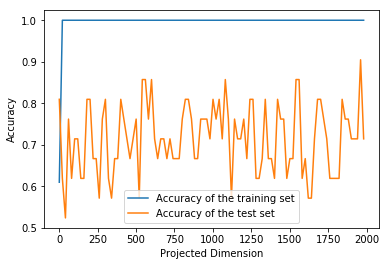

In [10]:
from sklearn.random_projection import GaussianRandomProjection
### TODO ### 
upperbnd = d
project_dimensions = range(1,upperbnd,int((upperbnd )/100))
#############
test_accuracy = []
training_accuracy = []
s = 20
for r in project_dimensions:   
    # 3)    project the data matrix $X \rightarrow XW$ using Gaussian and fit, transform and score using Logistic Regression
    W = GaussianRandomProjection(n_components=r)
    X_projected = W.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_projected, y, test_size=0.33)
    log_reg_p = LogisticRegression(C = C0, solver='lbfgs') # , multi_class = "multinomial"
    log_reg_p.fit(X_train, y_train)
    trainscore = log_reg_p.score(X_train,y_train)
    training_accuracy.append(trainscore)
    testscore = log_reg_p.score(X_test,y_test)
    test_accuracy.append(testscore)
    #############
    # print ("project dimension %4d gives: (train, test) =  (%.4f, %.4f)" % (r, trainscore,testscore))
# coef_recover = log_regt.coef_.dot(X_train.transpose())

plt.plot(project_dimensions,training_accuracy, label='Accuracy of the training set')
plt.plot(project_dimensions,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Projected Dimension')
plt.legend()
index_max = np.argmax(test_accuracy)
print("Best score was for r =%5d with: (train, test) =  (%.4f, %.4f)"% (project_dimensions[index_max], training_accuracy[index_max],test_accuracy[index_max]))

### ==> d is not big enough to choose a good r

## Exercise 2:

In class we used 
$$ X \rightarrow W^\top X $$
But here it is instead
$$ X \rightarrow X W $$



Now we will train a model using a large text based data set. For this you need to code the following random transform $W \in \mathbb{R}^{d \times r}$ that takes a sparsity parameter $s$ as an input and outputs a matrix

$$ W_{ij}  = \sqrt{\frac{s}{r}}
\begin{cases}
1 \quad & \mbox{with probability }\frac{1}{2s} \\
0 \quad & \mbox{with probability }1-\frac{1}{s} \\
-1 \quad & \mbox{with probability }\frac{1}{2s} 
\end{cases}$$

* Code a function Generate_Sparse_Transform$(s,r,d)$ that takes an input  
   * sparsity parameter  $s$
   * input dimension $d \in \mathbb{N}$
   * lower dimensional projected dimension $r \in \mathbb{N}$
and gives as outputs the matrix $W$ stored in an efficient sparse format such as the CSC formart (see scipy.sparse.csc_matrix)

* Code a function Apply_Sparse_Transform$(R,X)$ that takes an input
   * the random transform $W$ as generated by  Generate\_sparse\_transform$(s,r,d)$
   * a given data matrix $X \in \mathbb{R}^{n\times d}$
the output will be $XW$.


*Note* if you have not implemented this efficiently, you will probably run out of memory!  


We will test if random projections are able to preserve pairwise distances by applying K-Neighrest Neighbors to projected data.

1) [6pts] Code the above two functions (their stub is provided below)


2) [1pt] Load the data set X. Then fit, transform and score sklearn's KNeighborsClassifier on this data, where 
$X = $ {anthracyclineTaxaneChemotherapy, sector.scale}. Below you will find how to load this data.

3) [3pts] Repeat the previous step, but first randomly project that data using X -> XW. Repeat this test for different values of the sparsity parameter s and projected dimension parameter r. What can you conclude? 

*Hint* As a rule of thumb $s = \sqrt{r}$, $s= \log(r)$ or simply $s=20$ often works well.


In [11]:
import scipy
from sklearn.utils.extmath import safe_sparse_dot   ## <-- I recommend using this function
from sklearn.utils.random import sample_without_replacement  ## <-- I recommend using this function
from scipy.sparse import issparse, csc_matrix

def GenerateSparseTransform(s,r,d):

    data = np.sqrt(s/r) * np.random.choice([-1,0,1] , [d,r] , [1/(2*s), 1-1/s, 1/(2*s)])
    
    W = csc_matrix(data).toarray()
    
    return W

def ApplySparseTransform(W,X_):
#     W   : Sparse randomly generated matrix of size d by r
#     X_  : Data matrix to be compressed, of size n by d
#    NOTE: The dimensions of W and X_ are such that the product X_*W is defined (which is different that what we used in class)

    Xtransformed = safe_sparse_dot(X_, W)
    
    return Xtransformed

## Load and test easier data set *anthracyclineTaxaneChemotherapy*

In [12]:
from sklearn.datasets import fetch_openml
chemo = fetch_openml(name='anthracyclineTaxaneChemotherapy')

In [13]:
X = chemo.data
y = chemo.target

### if fetch_openml fails  
**ALTERNATIVE HACK for loading the data**
  
* downloard the data from data set in arff format from: https://www.openml.org/d/1085
 
* place data in the same folder as this notebook and run the code in the next cell

In [14]:
## ALTERNATIVE HACK for loading anthracyclineTaxaneChemotherapy ## 
from scipy.io import arff
dataset = arff.loadarff('phpCLGrjq.arff')
import pandas as pd
Xdf = pd.DataFrame(dataset[0])
Xy = Xdf.values
n_rows, n_cols = Xy.shape
X = Xy[:,:-1]
X = np.float_(X)
y = Xy[:,-1]
y = (np.int_(y))*2-3

In [15]:
# split test and training. Only use 20% of data for testing because data set is small. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) 
n2, d = X_train.shape
print('{n} training data points and {d} features'.format(n = n2,d =d))

127 training data points and 61359 features


In [16]:
# 2) fit, transform and score the knn Classifier
n_neighbors = 2 # <-- use this number of neighbours
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train,y_train)
trainscore = knn.score(X_train, y_train)
training_accuracy.append(trainscore)
testscore = knn.score(X_test, y_test)
test_accuracy.append(knn.score(X_test, y_test))
print ("project dim %5d gives: (train, test) =  (%.4f, %.4f)" % (d, trainscore,testscore))

project dim 61359 gives: (train, test) =  (0.8425, 0.5625)


project dim    30 gives: (train, test) =  (0.7953, 0.5938)
project dim   408 gives: (train, test) =  (0.8661, 0.5625)
project dim   786 gives: (train, test) =  (0.8346, 0.6250)
project dim  1164 gives: (train, test) =  (0.8425, 0.5938)
project dim  1542 gives: (train, test) =  (0.8661, 0.6250)
project dim  1920 gives: (train, test) =  (0.8661, 0.6875)
project dim  2298 gives: (train, test) =  (0.8268, 0.5938)
project dim  2676 gives: (train, test) =  (0.8504, 0.5625)
project dim  3054 gives: (train, test) =  (0.8425, 0.5938)
project dim  3432 gives: (train, test) =  (0.8504, 0.5938)
Best score was for r = 1920 with: (train, test) =  (0.8661, 0.6875)


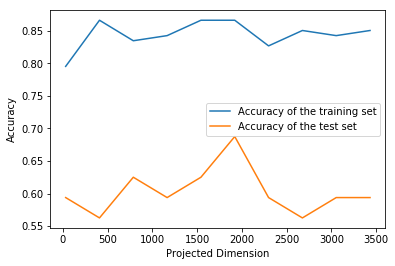

In [17]:
test_accuracy     = []
training_accuracy = []
n_neighbors       = 2  #< -- I recommend 2 neighbors

## Suggested range of projected dimensions:
upperbnd = int(min(30*n2,d/2))
minbnd   = int(max(n2/20,d/2000))
project_dimensions = range(minbnd,upperbnd,int((upperbnd -minbnd)/10))

knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    
for r in project_dimensions:
    W        = GenerateSparseTransform(np.log(r),r,d) # function coded above
    Xt_train = ApplySparseTransform(W,X_train)  # function coded above
    Xt_test  = ApplySparseTransform(W,X_test)  # function coded above
    knn.fit(Xt_train,y_train)
    trainscore = knn.score(Xt_train, y_train)
    testscore  = knn.score(Xt_test, y_test)
    training_accuracy.append(trainscore)
    test_accuracy.append(knn.score(Xt_test, y_test))
    print ("project dim %5d gives: (train, test) =  (%.4f, %.4f)" % (r, trainscore,testscore))

list_proj_dims = list(project_dimensions)
plt.plot(list_proj_dims,training_accuracy, label='Accuracy of the training set')
plt.plot(list_proj_dims,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Projected Dimension')
plt.legend()
index_max = np.argmax(test_accuracy)
print("Best score was for r =%5d with: (train, test) =  (%.4f, %.4f)"% (list_proj_dims[index_max], training_accuracy[index_max],test_accuracy[index_max]))

## Load and test HARDER data set *sector.scale*  
**(only try this data set after successfully testing the anthracyclineTaxaneChemotherapy data set)**

In [18]:
# Download the data set from:
# https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/sector/sector.scale.bz2
# place data in the same folder as this python notebook
dataname = "sector.scale"  
X, y = get_data(dataname)
n, d = X.shape
print('{n} data points and {d} features'.format(n = n,d =d))

6412 data points and 55197 features


In [19]:
# split test and training 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
n3, d = X_train.shape
print('{n} trainig data points and {d} features'.format(n = n3,d =d))

4296 trainig data points and 55197 features


In [20]:
### TODO ### 
## repeat the same experiments for this larger data set
## HINT: Only test project dimensions r <= int(min(2*n,d/2))
#############

project dim   214 gives: (train, test) =  (1.0000, 0.7750)
project dim  1051 gives: (train, test) =  (1.0000, 0.8724)
project dim  1888 gives: (train, test) =  (1.0000, 0.8757)
project dim  2725 gives: (train, test) =  (1.0000, 0.8790)
project dim  3562 gives: (train, test) =  (1.0000, 0.8809)
project dim  4399 gives: (train, test) =  (1.0000, 0.8819)
project dim  5236 gives: (train, test) =  (1.0000, 0.8823)
project dim  6073 gives: (train, test) =  (1.0000, 0.8819)
project dim  6910 gives: (train, test) =  (1.0000, 0.8809)
project dim  7747 gives: (train, test) =  (1.0000, 0.8819)
project dim  8584 gives: (train, test) =  (1.0000, 0.8828)
Best score was for r = 8584 with: (train, test) =  (1.0000, 0.8828)


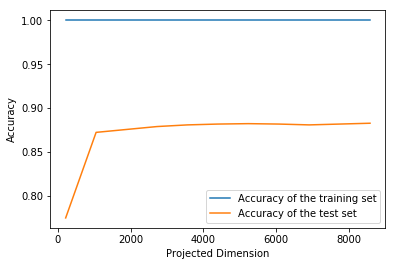

In [21]:
test_accuracy     = []
training_accuracy = []
n_neighbors = 1   ## <-- I recommend using this
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

upperbnd = int(min(2*n3,d/2))
minbnd   = int(max(n3/20,d/2000))
project_dimensions = range(minbnd,upperbnd,int((upperbnd -minbnd)/10))

for r in project_dimensions:  
    ### TODO ###   
    # 3)    project the data matrix $X \rightarrow XW$ using Gaussian and fit, transform and score using knn
    W          = GenerateSparseTransform(20,r,d)
    Xt_train   = ApplySparseTransform(W,X_train)
    Xt_test    = ApplySparseTransform(W,X_test)
    knn.fit(Xt_train,y_train)
    trainscore = knn.score(Xt_train, y_train)
    testscore  = knn.score(Xt_test, y_test)
    training_accuracy.append(trainscore)
    test_accuracy.append(testscore)
    #############
    print ("project dim %5d gives: (train, test) =  (%.4f, %.4f)" % (r, trainscore,testscore))

list_proj_dims = list(project_dimensions)
plt.plot(list_proj_dims,training_accuracy, label='Accuracy of the training set')
plt.plot(list_proj_dims,test_accuracy, label='Accuracy of the test set')
plt.ylabel('Accuracy')
plt.xlabel('Projected Dimension')
plt.legend()
index_max = np.argmax(test_accuracy)
print("Best score was for r =%5d with: (train, test) =  (%.4f, %.4f)"% (list_proj_dims[index_max], training_accuracy[index_max],test_accuracy[index_max]))

Since n=1, we have an accuracy of 1 on the training set.

### => We tried different value of s as suggest in the text but we ended up with the same result. As explain in the lesson, it is working here because d > 10e4 so we can find a good r.

## Bonus question

Using the Jonhson-Lindenstrauss Lemma, we can have an estimate for the projected dimension using

$$r = \frac{1}{\epsilon^2}\log(n/\delta) $$

1) Write a function for calculating this given suggested project dimension r. 
2) Test for each of the above data sets with $\epsilon = 0.05 = \delta$ and compare to your results. 

In [22]:
def Jonhson_Lindenstrauss_Lemma(epsilon,delta,n):
    r = 1/epsilon**2 * np.log(n/delta)
    return r

In [23]:
epsilon = 0.05
delta = 0.05

In [24]:
Jonhson_Lindenstrauss_Lemma(epsilon,delta,n1)

2683.721736103319

In [25]:
Jonhson_Lindenstrauss_Lemma(epsilon,delta,n2)

3135.9677440050327

In [26]:
Jonhson_Lindenstrauss_Lemma(epsilon,delta,n3)

4544.468763897076